In [10]:
import pandas as pd
import numpy as np
import copy
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
import sklearn
import matplotlib.pyplot as plt

In [11]:
data = pd.read_csv('amazon.csv')

In [12]:
max_value = 0
for col_name in data.columns:
    max_value = max(max_value, np.max(data[col_name]))
print(max_value)

312153


In [13]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
# число значений у признаков
max_value = 0
for col_name in data.columns:
    max_value = max(max_value, np.max(data[col_name]))
print(max_value)

312153


In [15]:
def display_auc(y_true, y_predict):
    print("AUC:", sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true))
    (fpr, tpr, thresholds) = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_predict)
    plt.plot(fpr, tpr)
    plt.show()

def get_auc(y_true, y_predict):
    return sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true)

In [16]:
def unique_with_count(input_array): # (value, count)
    buf = copy.deepcopy(input_array)
    buf = buf[buf == buf]
    buf = np.sort(buf)
    
    Y = np.concatenate((buf[1:], np.array([np.nan])))
    lens_seg = np.cumsum(np.ones(buf.shape[0]))
    val = buf[buf != Y]
    lens_seg = lens_seg[buf != Y]
    lens_seg = np.asarray(np.concatenate((lens_seg[0:1], np.diff(lens_seg))), dtype = int)
    return (val, lens_seg)


p_2 = np.zeros((X_train.shape[1], max_value + 1))
p = np.zeros((X_train.shape[1], max_value + 1))
f = np.zeros((X_train.shape[1], max_value + 1))
for col in range(X_train.shape[1]):
    (unique_value, count) = unique_with_count(X_train.iloc[:, col])
    cur_f = count
    cur_p = (count + 0.0) / X_train.shape[0]
    cur_p_2 = count * (count - 1.0) / X_train.shape[0] / (X_train.shape[0] - 1)
    sum_p_2 = np.zeros(unique_value.shape[0])
    for i in range(unique_value.shape[0]):
        sum_p_2[i] = np.sum(cur_p_2[cur_p < cur_p[i]])
    
    f[col][unique_value] = cur_f
    p[col][unique_value] = cur_p
    p_2[col][unique_value] = sum_p_2
    
log_f = np.log(f + 1)


In [17]:
def find_optimal_k(X_train, y_train, X_test, y_test, MAXK, metric, metric_params = None):
    MAXK += 1
    classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=MAXK, 
                                                        algorithm='brute', 
                                                        metric=metric,
                                                        metric_params=metric_params)
    classifier.fit(X_train, y_train)
    nearest_class = classifier.kneighbors(X_test, return_distance=0)
    precision = np.ndarray((MAXK, X_test.shape[0], 2))
    for ind_object in range(X_test.shape[0]):
        histohram = np.zeros(2)
        for k in range(0, MAXK):
            histohram[y_train.iloc[nearest_class[ind_object][k]]] += 1
            precision[k, ind_object] = histohram / (k + 1)
    
    max_auc = 0.0
    max_k = 0;
    for k in range(0, MAXK):
        y_predict = precision[k, :, 1]
        cur_auc = get_auc(y_true = y_test, y_predict = y_predict)
        if (cur_auc > max_auc):
            max_auc = cur_auc
            max_k = k + 1
        
    return (max_auc, max_k)

In [18]:
def get_count_and_successed(X_train, y_train):
    count = [{} for i in range(X_train.shape[1])]
    successed = [{} for i in range(X_train.shape[1])]
    for col in range(X_train.shape[1]):
        value, len = unique_with_count(X_train.iloc[:, col])
        
        count[col] = {cur_value: 0 for cur_value in value}
        successed[col] = {cur_value: 0 for cur_value in value}
        for ind in range(X_train.shape[0]):
            count[col][X_train.iloc[ind, col]] += 1
            successed[col][X_train.iloc[ind, col]] += (y_train.iloc[ind] == 1)
        for cur_value in value:
            count[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] /= y_train.shape[0]
            
    return (count, successed)

In [19]:
def get_new_features(X, count, successed):
    cnt = 0
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            new_X[i, 3 * j] = count[j].get(X.iloc[i, j], 0)
            new_X[i, 3 * j + 1] = successed[j].get(X.iloc[i, j], 0)
            new_X[i, 3 * j + 2] = (new_X[i, 3 * j + 1] + 1) / (new_X[i, 3 * j] + 2)
            cnt += new_X[i, 3 * j] == 0;
    print(cnt)
    return new_X



In [20]:
def get_new_features_with_fold(X, y, CNT_FOLDS = 3):
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(CNT_FOLDS):
        ind = np.ndarray(((X.shape[0] + CNT_FOLDS - 1 - i) // CNT_FOLDS), dtype=int)
        other_ind = np.ndarray(X.shape[0] - ind.shape[0], dtype=int)
        cnt = 0
        cnt_other = 0
        for j in range(X.shape[0]):
            if (j % CNT_FOLDS == i):
                ind[cnt] = j
                cnt += 1
            else:
                other_ind[cnt_other] = j
                cnt_other += 1

        count, successed = get_count_and_successed(X.iloc[other_ind, :], y.iloc[other_ind])
        X_chunk_new = get_new_features(X.iloc[ind, :], count, successed)
        new_X[ind, :] = X_chunk_new
    return new_X


In [22]:
count, successed = get_count_and_successed(X_train, y_train)

In [23]:
new_X_train = get_new_features(X_train, count, successed)
new_X_test = get_new_features(X_test, count, successed)

0
2214


AUC: 0.788718055439


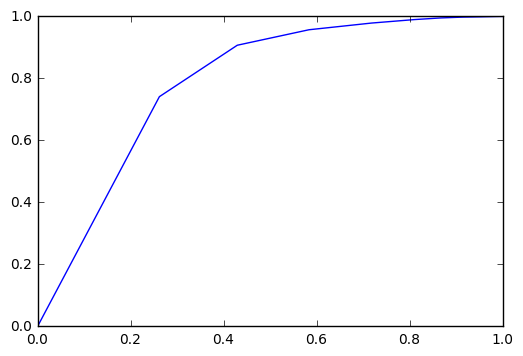

In [24]:
#WITHOUT FOLDING
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, 
                                               algorithm='brute', 
                                               metric='euclidean')

neigh.fit(new_X_train, y_train)


y = neigh.predict_proba(new_X_test)
y = y[:, 1]

display_auc(y_true = y_test, y_predict = y)

In [25]:
find_optimal_k(new_X_train, y_train, new_X_test, y_test, MAXK=15, metric='euclidean') #WITHOUT FOLDING

(0.79678798609179213, 14)

2383
2421
2411
2214
AUC: 0.763562263815


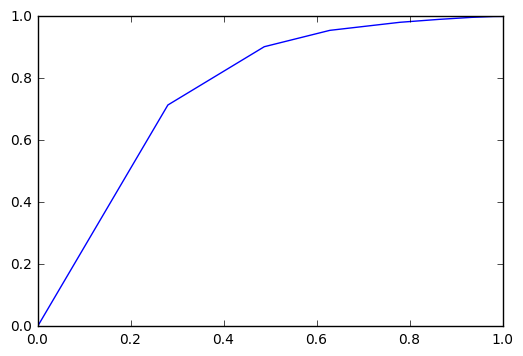

In [26]:
#WITH FOLDING
CNT_FOLDS = 3
new_X_train = get_new_features_with_fold(X_train, y_train, CNT_FOLDS)


count, successed = get_count_and_successed(X_train, y_train)
new_X_test = get_new_features(X_test, count, successed)


neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, 
                                               algorithm='brute', 
                                               metric='euclidean')

neigh.fit(new_X_train, y_train)


y = neigh.predict_proba(new_X_test)
y = y[:, 1]

display_auc(y_true = y_test, y_predict = y)

In [27]:
find_optimal_k(new_X_train, y_train, new_X_test, y_test, MAXK=30, metric='euclidean') #WITH FOLDING

(0.77708562015813154, 16)